In [99]:
# reloading modules if needed
from importlib import reload

# first import the whole package
import PyPolyCrystals

# then (re)load all the functions in the .py files in the .../PyPolyCrystals/ directory:
from PyPolyCrystals import *
reload(PyPolyCrystals)
from PyPolyCrystals import *

In [2]:
import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)
#torch.set_default_device(device)

In [3]:
# NEW EXAMPLE with input from MTEX

file = "../../data/2D_Tata_Steel_new_example/sample_lc_steel_grain_file_MTEX2.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt)
A = A.to(device,dtype=dt)
TV = TV.to(device,dtype=dt)
N, D = X.shape
#M=4000

In [4]:
X[:,0].min()

tensor(0.5931551924, device='cuda:0')

In [5]:
dom_x = [-0.5,900.5]
dom_y = [-1.0,999.52728]
#dom_y = [-900.5,0.5]
#dom_x = [-999.52728,1.0]
#dom_x = [X[:,0].min(), X[:,0].max()]
#dom_y = [X[:,1].min(), X[:,1].max()]
domain = torch.tensor([dom_x,dom_y])

In [6]:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())
#print("Largest grain: ", torch.max(TV).cpu().numpy(), ". Smallest grain: ",torch.min(TV).cpu().numpy()),# ". Ratio: ",(torch.max(TV)/torch.min(TV)).cpu().numpy())

Largest grain:  2078.17132503499 Smallest grain:  9.5262750001595


In [7]:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess!
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.01
                  )

In [8]:
apd1.N

4476

In [9]:
# but the error is still huge:
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  412.0448384603658


In [10]:
# and now solve the OT problem to get optimal weights:
apd1.find_optimal_W(max_iter = 5000)

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0953290914, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -67261170.800253
         Iterations: 335
         Function evaluations: 586
It took 82.10249972343445 seconds to find optimal W.


In [11]:
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.9967958390122936


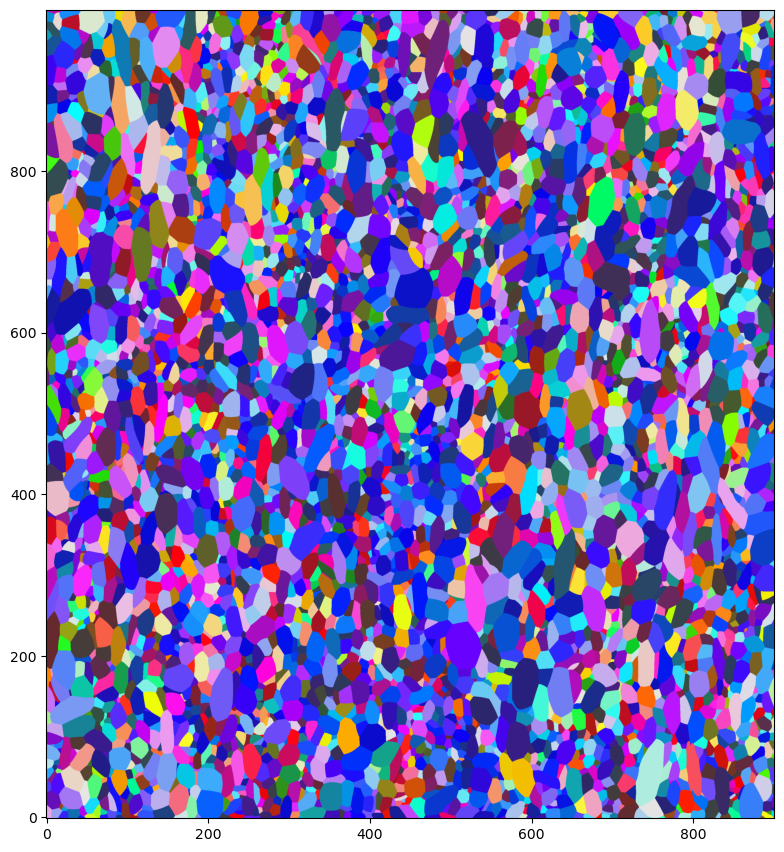

In [12]:
#fig, ax1 = apd1.plot_apd(color_by = EBSD[:,orientation_id[-1]])
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(img2, origin='lower', extent = torch.flatten( apd1.domain ).tolist())
#ax1.invert_yaxis()
#ax1.invert_xaxis()

In [30]:
# first rectangular grid:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 0.5, apd1.domain[i,1] - 0.5, 901)

L1 = int(1154/2)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0, apd1.domain[i,1] - 1.0 - np.sqrt(3)/2, L1)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)

In [34]:
apd1.domain[1,1]

tensor(999.5272800000, device='cuda:0')

In [33]:
grid_y[-1]

tensor(997.6612545962)

In [39]:
# second rectangular grid:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 1.0, apd1.domain[i,1] - 1.0, 900)

L1 = int(1154/2)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0 + np.sqrt(3)/2, apd1.domain[i,1] - 1.0, L1)

mesh2 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels2 = torch.stack(mesh2, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels2b = pixels2.reshape(-1, apd1.D)

In [43]:
pixels = torch.cat((pixels1b,pixels2b))
PS = np.sqrt(3.0)/2.0 * torch.ones(pixels.shape[0])

In [44]:
PS.sum()

tensor(899953.6810285023)

In [45]:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt)
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt)

In [46]:
apd1.Y.view(1,apd1.Y.shape[0],apd1.D).shape

torch.Size([1, 1039177, 2])

In [47]:
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [48]:
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  55.82022004232618


In [49]:
W_optimal = copy.deepcopy(apd1.W)

In [50]:
apd1.set_W(W = W_optimal)

In [51]:
img_optimal = copy.deepcopy(apd1.assemble_apd())

In [52]:
My_pixel_data = torch.cat((apd1.Y,img_optimal[...,None]), 1)

In [53]:
file = "../../data/2D_Tata_Steel_new_example/grainIDs2.txt"

In [55]:
EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

In [56]:
#II = [(torch.norm(EBSD_pixel_data[:,0:2][i] - My_pixel_data[:,0:2],dim=1) < 0.5).nonzero().item() for i in range(EBSD_pixel_data.shape[0]) ]

In [ ]:
img_optimal[II] - EBSD_pixel_data[:,2] + 1

In [86]:
file = "../../data/2D_Tata_Steel_new_example/Sample_LC steel.ang"
data = np.loadtxt(file)

In [87]:
file = "../../data/2D_Tata_Steel_new_example/grains_mean_orientation.txt" 
crystal_orient_grains = np.loadtxt(file)

In [88]:
crystal_orient_grains = torch.from_numpy(crystal_orient_grains).to(device,dtype=dt)

In [89]:
data.shape

(1039177, 10)

In [59]:
data_torch = torch.from_numpy(data).to(device,dtype=dt)

In [68]:
data_torch_new = copy.deepcopy(data_torch)

In [60]:
data_torch[:,3:5]

tensor([[  0.0000000000,   0.0000000000],
        [  1.0000000000,   0.0000000000],
        [  2.0000000000,   0.0000000000],
        ...,
        [897.5000000000, 998.5272800000],
        [898.5000000000, 998.5272800000],
        [899.5000000000, 998.5272800000]], device='cuda:0')

In [61]:
II = [(torch.norm(data_torch[:,3:5][i] - My_pixel_data[:,0:2],dim=1) < 0.5).nonzero().item() for i in range(data_torch.shape[0]) ]

In [82]:
My_pixel_data[II][:,2]

tensor([  11.,   11.,   11.,  ..., 4475., 4475., 4475.], device='cuda:0')

In [70]:
img_optimal.min()

tensor(0, device='cuda:0')

In [83]:
img_optimal[II]

tensor([  11,   11,   11,  ..., 4475, 4475, 4475], device='cuda:0')

In [67]:
data_torch[0,0:3]

tensor([1.6469000000, 1.5838400000, 1.3303600000], device='cuda:0')

In [66]:
My_pixel_data[0,:]

tensor([ 0.,  0., 11.], device='cuda:0')

In [73]:
data_torch[0,:]

tensor([1.6469000000e+00, 1.5838400000e+00, 1.3303600000e+00, 0.0000000000e+00,
        0.0000000000e+00, 1.4238000000e+05, 9.6700000000e-01, 0.0000000000e+00,
        1.0000000000e+00, 5.1400000000e-01], device='cuda:0')

In [81]:
crystal_orient_grains[img_optimal[II]].shape

torch.Size([1039177, 3])

In [80]:
data_torch[:,0:3].shape

torch.Size([1039177, 3])

In [84]:
data_torch[0:2,:]

tensor([[1.6469000000e+00, 1.5838400000e+00, 1.3303600000e+00, 0.0000000000e+00,
         0.0000000000e+00, 1.4238000000e+05, 9.6700000000e-01, 0.0000000000e+00,
         1.0000000000e+00, 5.1400000000e-01],
        [1.6459300000e+00, 1.5831700000e+00, 1.3305200000e+00, 1.0000000000e+00,
         0.0000000000e+00, 1.4457880000e+05, 9.1700000000e-01, 0.0000000000e+00,
         1.0000000000e+00, 4.8700000000e-01]], device='cuda:0')

In [85]:
My_pixel_data[II][0:2,:]

tensor([[ 0.,  0., 11.],
        [ 1.,  0., 11.]], device='cuda:0')

In [96]:
My_pixel_data[II][1801,:]

tensor([ 0.0000000000,  1.7320507892, 11.0000000000], device='cuda:0')

In [97]:
data_torch[1801,:]

tensor([1.9701400000e+00, 5.4790000000e-01, 4.1333700000e+00, 0.0000000000e+00,
        1.7320500000e+00, 1.0511940000e+05, 3.6700000000e-01, 0.0000000000e+00,
        1.0000000000e+00, 1.1690000000e+00], device='cuda:0')

In [100]:
crystal_orient_grains[img_optimal[II]][1801]

tensor([1.9672533065, 0.5496002806, 4.1364580057], device='cuda:0')

In [101]:
# this is what we want:
data_torch_new[:,0:3] = crystal_orient_grains[img_optimal[II]]

In [102]:
data_torch_new[0,:]

tensor([1.9672533065e+00, 5.4960028060e-01, 4.1364580057e+00, 0.0000000000e+00,
        0.0000000000e+00, 1.4238000000e+05, 9.6700000000e-01, 0.0000000000e+00,
        1.0000000000e+00, 5.1400000000e-01], device='cuda:0')

In [104]:
data_new = np.array(data_torch_new.cpu())
data_new

array([[1.96725331, 0.54960028, 4.13645801, ..., 0.        , 1.        ,
        0.514     ],
       [1.96725331, 0.54960028, 4.13645801, ..., 0.        , 1.        ,
        0.487     ],
       [1.96725331, 0.54960028, 4.13645801, ..., 0.        , 1.        ,
        0.702     ],
       ...,
       [4.49906852, 0.99411122, 5.0527335 , ..., 0.        , 1.        ,
        0.605     ],
       [4.49906852, 0.99411122, 5.0527335 , ..., 0.        , 1.        ,
        0.375     ],
       [4.49906852, 0.99411122, 5.0527335 , ..., 0.        , 1.        ,
        0.63      ]])

In [111]:
fmt = '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.1f', '%1.3f', '%d', '%d', '%1.3f'

In [112]:
np.savetxt("ebsd_data_for_MTEX.txt",data_new, fmt=fmt)